In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

### Load data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### Remove constant columns

In [3]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

#### Remove duplicated columns

In [4]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [5]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

### Feature selections

In [29]:
Xdf_tr = df_train.iloc[:,1:-1]
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 25 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]

In [30]:
selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]
Xdf=df_train[features]

Chi2 & F_classif selected 66 features


### Remove highly correlated features

('The shape of correlation coefficient matrix:', (60, 60))
('Variables pairs:', 1770)
('Checked pairs:', 1770)

:0: FutureWarning: IPython widgets are experimental and may change in the future.
/home/nguyen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



('Columns to be removed due to high correlation:', 38)
('New combi shape:', (76020, 22))


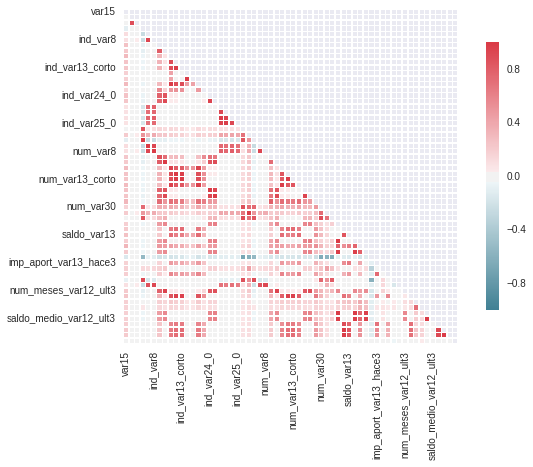

In [9]:
corrFloat = Xdf.corr()
print ("The shape of correlation coefficient matrix:", corrFloat.shape)

import seaborn as sns
# Below code URL: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
mask = np.zeros_like(corrFloat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrFloat, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

# threshold is arbitrary, but in this example threshold = +/-0.8 (Pearson's correlation coefficient)

# check the number of unique combinations of 2 variables
import itertools
pairs = list(itertools.combinations(Xdf.columns, 2))
print ("Variables pairs:", len(pairs))

hiCor = []
hiCorCounter = 0
for i in range(Xdf.shape[1]):
    for j in range(0, i):
        if corrFloat[Xdf.columns[i]][j] > 0.8 or Xdf[Xdf.columns[i]][j] < -0.8:
            #hiCor.append(Xdf.index[j])
            hiCor.append(Xdf.columns[j]) #list(Xdf.columns.values)
        hiCorCounter += 1

# get unique values from the list
hiCor = list(set(hiCor))

print ("Checked pairs:", hiCorCounter)
print ("Columns to be removed due to high correlation:", len(hiCor))

Xdf.drop(hiCor, axis=1, inplace=True)

print ("New combi shape:", Xdf.shape)

In [31]:
#from sklearn import preprocessing
#X_tr = preprocessing.scale(Xdf.as_matrix())

X_tr = Xdf.as_matrix()
t_tr = df_train['TARGET'].as_matrix()

In [32]:
# length of dataset
len_tr = len(X_tr)

# classifier
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.03, nthread=4, 
                        subsample=0.95, colsample_bytree=0.85, seed=4242)

X_fit, X_eval, y_fit, y_eval= train_test_split(X_tr, t_tr, test_size=0.3)

# fitting
clf.fit(X_tr, t_tr, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])

print('Overall AUC:', roc_auc_score(t_tr, clf.predict_proba(X_tr)[:,1]))

Will train until validation_0 error hasn't decreased in 20 rounds.
[0]	validation_0-auc:0.731036
[1]	validation_0-auc:0.745701
[2]	validation_0-auc:0.742258
[3]	validation_0-auc:0.768667
[4]	validation_0-auc:0.785323
[5]	validation_0-auc:0.775142
[6]	validation_0-auc:0.758474
[7]	validation_0-auc:0.783107
[8]	validation_0-auc:0.768277
[9]	validation_0-auc:0.781429
[10]	validation_0-auc:0.784270
[11]	validation_0-auc:0.792365
[12]	validation_0-auc:0.793399
[13]	validation_0-auc:0.795071
[14]	validation_0-auc:0.795219
[15]	validation_0-auc:0.795960
[16]	validation_0-auc:0.797194
[17]	validation_0-auc:0.797088
[18]	validation_0-auc:0.795933
[19]	validation_0-auc:0.796102
[20]	validation_0-auc:0.796083
[21]	validation_0-auc:0.796646
[22]	validation_0-auc:0.797147
[23]	validation_0-auc:0.798655
[24]	validation_0-auc:0.798624
[25]	validation_0-auc:0.799433
[26]	validation_0-auc:0.800093
[27]	validation_0-auc:0.799903
[28]	validation_0-auc:0.800226
[29]	validation_0-auc:0.800808
[30]	validati

('Overall AUC:', 0.86859077094657133)


[349]	validation_0-auc:0.862745


In [33]:
id_test = df_test['ID']

#X_test = df_test[features].as_matrix()
X_test = preprocessing.scale(df_test[features].as_matrix())

In [34]:
t_pred=clf.predict_proba(X_test)[:,1]

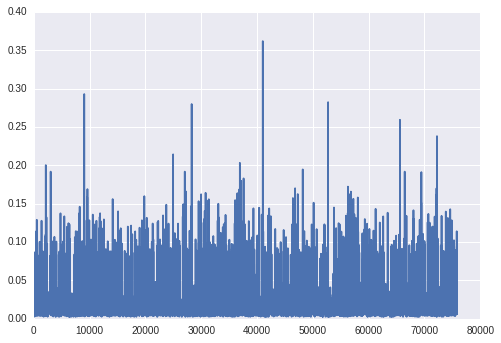

In [35]:
plt.plot(t_pred)

In [36]:
submission = pd.DataFrame({"ID":id_test, "TARGET": t_pred})
submission.to_csv("./data/submission.csv", index=False)